In [1]:
# Created at 10:03 PM 7/11/2025 - Shakil
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Transformer Insulation Life vs Hottest-Spot Temperature

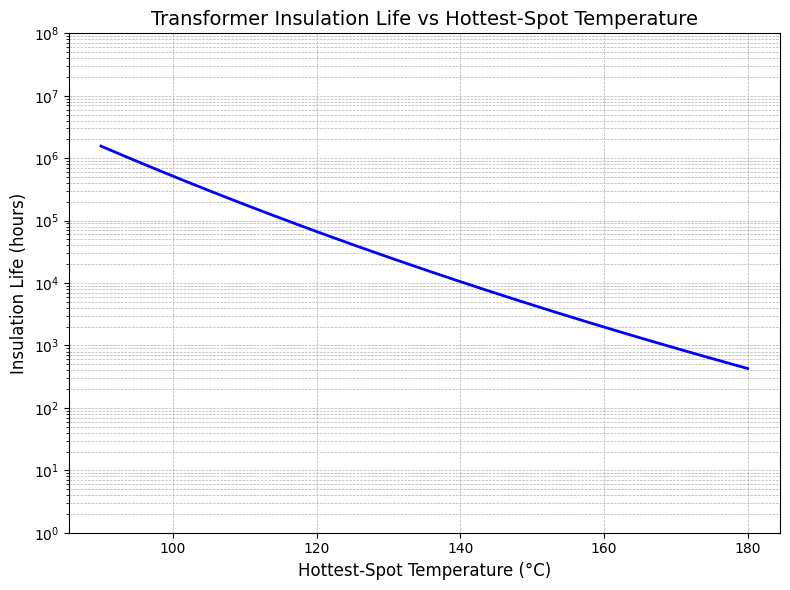

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
A_prime = 1.8e-12  # A'
B = 15000          # Arrhenius slope
theta_hs_range = np.linspace(90, 180, 500)  # Hottest-spot temperature in °C
T_winding = 273.15 + theta_hs_range         # Convert to Kelvin

# Compute insulation life using Arrhenius equation
LIFE = A_prime * np.exp(B / T_winding)

# Plot
plt.figure(figsize=(8, 6))
plt.semilogy(theta_hs_range, LIFE, color='blue', linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title("Transformer Insulation Life vs Hottest-Spot Temperature", fontsize=14)
plt.xlabel("Hottest-Spot Temperature (°C)", fontsize=12)
plt.ylabel("Insulation Life (hours)", fontsize=12)
plt.ylim(1, 1e8)
plt.tight_layout()
plt.show()


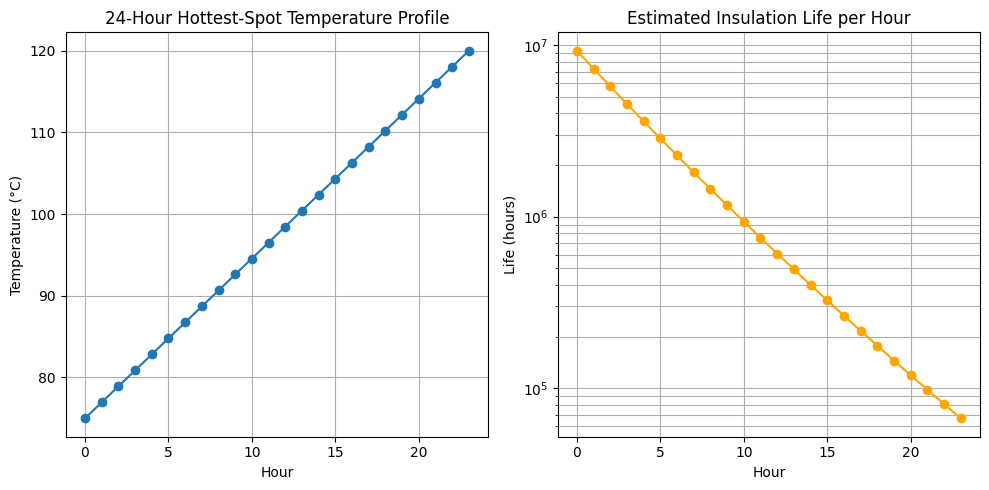

Estimated total insulation loss of life over 24 hours: 0.0082%


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
A_prime = 1.8e-12     # A'
B = 15000             # Arrhenius slope
nominal_life = 180000 # hours

# Simulated 24-hour hottest-spot temperature profile (°C)
theta_hs_24hr = np.linspace(75, 120, 24)  # or use your measured 24-hour data
T_kelvin = theta_hs_24hr + 273.15         # Convert to Kelvin

# Compute insulation life at each hour using Arrhenius equation
life_each_hour = A_prime * np.exp(B / T_kelvin)

# Compute aging rate per hour relative to reference life at 110°C (383.15 K)
life_ref = A_prime * np.exp(B / 383.15)   # Reference life at 110°C
relative_aging_rate = life_ref / life_each_hour

# Loss of Life (%) over 24 hours
loss_of_life_percent = 100 * np.sum(1 / life_each_hour)  # Sum of 1-hour aging fractions * 100

# === Plotting ===
plt.figure(figsize=(10, 5))

# Plot Temperature Profile
plt.subplot(1, 2, 1)
plt.plot(range(24), theta_hs_24hr, marker='o')
plt.title("24-Hour Hottest-Spot Temperature Profile")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.grid(True)

# Plot Insulation Life Profile
plt.subplot(1, 2, 2)
plt.semilogy(range(24), life_each_hour, marker='o', color='orange')
plt.title("Estimated Insulation Life per Hour")
plt.xlabel("Hour")
plt.ylabel("Life (hours)")
plt.grid(True, which="both")

plt.tight_layout()
plt.show()

# Output summary
print(f"Estimated total insulation loss of life over 24 hours: {loss_of_life_percent:.4f}%")


# Detailed Transformer Model Transformer model

In [4]:
# transformer_model_standalone.py
# Self-contained version of transformer_thermal_models (core logic only)

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


class Transformer:
    def __init__(self):
        self.MVA_rated = 52
        self.MVA_loss = 28
        self.T_loss = 75
        self.P_wr = 51690
        self.P_er = 0
        self.P_sr = 21078
        self.P_cr = 36986
        self.P_coe = 36986
        self.E_hs = 1
        self.M_cc = 75600
        self.M_tank = 31400
        self.liquid_volume = 4910
        self.T_ambr = 30.0
        self.T_wr = 63
        self.T_hsr = 80
        self.T_tor = 55
        self.T_bor = 25
        self.T_k = 234.5
        self.H_hs = 1.0
        self.tau_w = 5.0
        self.cooling_system = 'ONAN'
        self.winding_material = 'Copper'
        self.liquid_type = 'mineral oil'
        self.TUK = True
        self.solution = None

    def from_json(self, filename):
        import json
        with open(filename, 'r') as f:
            data = json.load(f)
            for k, v in data.items():
                setattr(self, k, v)


class LoadConditions:
    def __init__(self):
        self.time = None
        self.T_ambient = None
        self.load = None

    def update_profiles(self):
        self.Load_profile = interp1d(self.time, self.load, kind='previous', fill_value='extrapolate')
        self.T_ambient_profile = interp1d(self.time, self.T_ambient, kind='linear', fill_value='extrapolate')


class TransformerModel:
    def __init__(self, transformer: Transformer, load_conditions: LoadConditions):
        self.xfmr = transformer
        self.lc = load_conditions

    def solve_temperatures(self):
        xfmr, lc = self.xfmr, self.lc
        time = lc.time
        load = lc.load
        T_amb = lc.T_ambient

        def adjust_initial_temp(T, L, T_A, T_AR):
            return (T - T_AR) * L + T_A

        T_hs_0 = adjust_initial_temp(xfmr.T_hsr, load[0], T_amb[0], xfmr.T_ambr)
        T_to_0 = adjust_initial_temp(xfmr.T_tor, load[0], T_amb[0], xfmr.T_ambr)

        # Correction
        x = (xfmr.MVA_rated / xfmr.MVA_loss) ** 2
        t = (xfmr.T_k + xfmr.T_wr) / (xfmr.T_k + xfmr.T_loss)
        P_w = x * xfmr.P_wr * t
        P_e = x * xfmr.P_er / t
        P_s = x * xfmr.P_sr / t
        P_c = xfmr.P_cr

        R = (P_w + P_e + P_s) / P_c
        tau_to = 180.0  # Assume 3 hours unless calculated dynamically
        tau_w = xfmr.tau_w
        n = 0.8
        m = 0.8

        def clause_7(t, y):
            T_to, T_hs = y
            L = lc.Load_profile(t)
            T_a = lc.T_ambient_profile(t)
            dT_to = ((xfmr.T_tor * ((1 + L ** 2 * R) / (1 + R)) ** n) - (T_to - T_a)) / tau_to
            dT_hs = ((xfmr.T_hsr - xfmr.T_tor) * L ** (2 * m) - (T_hs - T_to)) / tau_w
            return [dT_to, dT_hs]

        t_span = (time[0], time[-1])
        t_eval = np.linspace(time[0], time[-1], len(time))

        sol = solve_ivp(clause_7, t_span, [T_to_0, T_hs_0], t_eval=t_eval, method='RK45')
        df = pd.DataFrame({
            'Time [Minutes]': sol.t,
            'Top Oil [C]': sol.y[0],
            'Hot Spot [C]': sol.y[1],
            'Ambient [C]': T_amb,
            'Load': load
        })
        xfmr.solution = df

    def estimate_loss_of_life(self):
        df = self.xfmr.solution
        T_hs = df['Hot Spot [C]'].values + 273.15
        t = df['Time [Minutes]'].values / 60

        B = 15000.0
        A = 9.8e-18
        T_ref = 110 + 273.15
        nominal_life = 180000

        V = np.exp((B / T_ref) - (B / T_hs))
        dt = np.diff(t, prepend=t[0])
        cumulative = np.cumsum(V * dt)
        Feqa = cumulative / (t + 1e-9)
        lol = (Feqa * t) * 100 / nominal_life
        self.xfmr.solution['Loss of Life [%]'] = lol

    def plot_results(self):
        df = self.xfmr.solution
        time_hr = df['Time [Minutes]'] / 60
        plt.figure(figsize=(10, 5))
        plt.plot(time_hr, df['Hot Spot [C]'], label='Hot Spot Temp')
        plt.plot(time_hr, df['Top Oil [C]'], label='Top Oil Temp')
        plt.xlabel('Time [hr]')
        plt.ylabel('Temperature [°C]')
        plt.legend()
        plt.grid(True)
        plt.title('Transformer Thermal Response')
        plt.show()


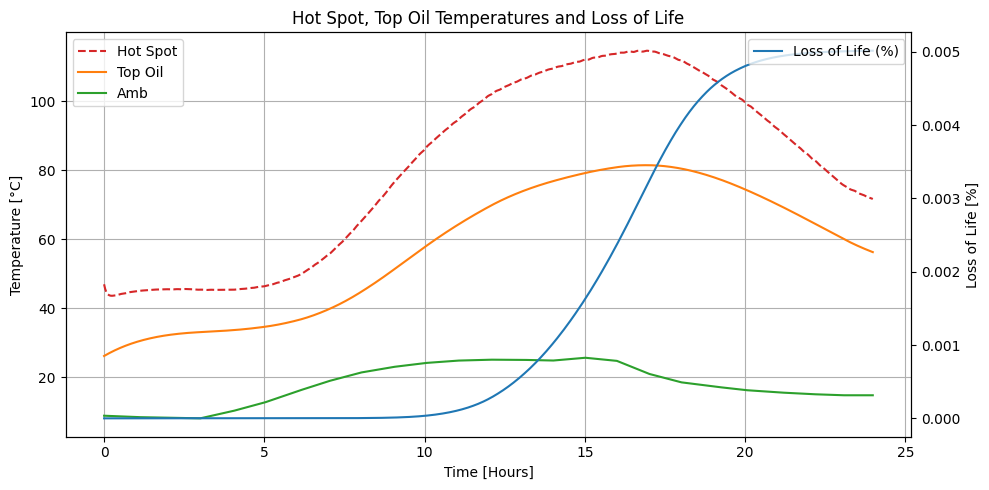

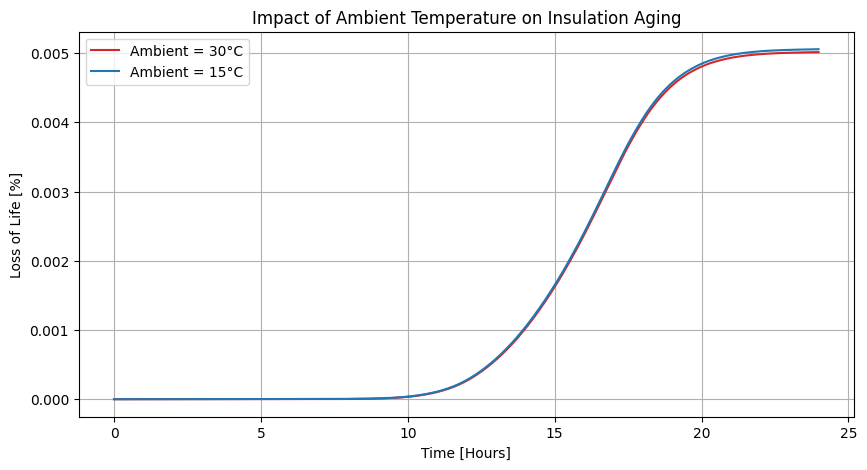

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hourly ambient temperature and load
temp = np.array([
    8.79, 8.39, 8.23, 8.03, 10.1, 12.6, 15.8, 18.8, 21.29, 22.9, 24.06, 24.76,
    25.04, 25.0, 24.78, 25.61, 24.69, 20.93, 18.48, 17.29, 16.22, 15.57, 15.07, 14.72
])
hourly_load = np.array([
   1.94, 1.80, 1.68, 1.60, 1.56, 1.57, 1.67, 1.93, 2.26, 2.56, 2.76, 2.86,
    2.96, 2.96, 2.97, 2.97, 2.98, 2.98, 2.86, 2.67, 2.47, 2.26, 2.04, 1.82
])/2.8

transformer_2_8MVA = {
    "MVA_rated": 2.8,
    "MVA_loss": 2.8,  # Assume same for simplicity
    "P_wr": 12027.0,  # Winding loss at rated load [W]
    "P_er": 0.0,      # Eddy loss [W]
    "P_sr": 3600.0,   # Stray loss [W] (assumed)
    "P_cr": 1800.0,   # Core loss [W] (assumed)
    "P_coe": 1800.0,  # Core loss when overexcited [W]
    "M_cc": 950.0,    # Core + coil mass [kg]
    "M_tank": 450.0,  # Tank mass [kg]
    "liquid_volume": 650.0,  # Oil volume [L]
    "E_hs": 1.3,
    "T_hsr": 85.0,
    "T_tor": 55.0,
    "T_bor": 25.0,
    "T_wr": 65.0,
    "T_k": 234.5,
    "H_hs": 1.0,
    "tau_w": 5.0,
    "cooling_system": "ONAN",
    "winding_material": "Copper",
    "liquid_type": "mineral oil",
    "TUK": True,
    "T_ambr": 30.0,
}

# Interpolate to minute resolution (1440 minutes = 24 hours)
time = np.arange(0, 1440)  # in minutes
time_hr = time / 60        # fractional hours
T_ambient = np.interp(time_hr, np.arange(24), temp)
load = np.interp(time_hr, np.arange(24), hourly_load)

# Set up transformer and load conditions
xfmr = Transformer()
# xfmr.from_json('spencerport_transformer_thermal_nameplate.json')
xfmr.__dict__.update(transformer_2_8MVA)

lc = LoadConditions()
lc.time = time
lc.load = load
lc.T_ambient = T_ambient
lc.update_profiles()

# Run model
model = TransformerModel(xfmr, lc)
model.solve_temperatures()
model.estimate_loss_of_life()

# === Plot Hot Spot, Top Oil, LOL ===
sol = model.xfmr.solution
time_hr = sol['Time [Minutes]'] / 60

fig, ax1 = plt.subplots(figsize=(10, 5))

# Temperature plot (left Y-axis)
ax1.plot(time_hr, sol['Hot Spot [C]'], label='Hot Spot', color='tab:red', linestyle='--')
ax1.plot(time_hr, sol['Top Oil [C]'], label='Top Oil', color='tab:orange')
ax1.plot(time_hr, sol['Ambient [C]'], label='Amb', color='tab:green')
ax1.set_xlabel('Time [Hours]')
ax1.set_ylabel('Temperature [°C]')
ax1.legend(loc='upper left')
ax1.grid(True)

# LOL plot (right Y-axis)
ax2 = ax1.twinx()
ax2.plot(time_hr, sol['Loss of Life [%]'], label='Loss of Life (%)', color='tab:blue')
ax2.set_ylabel('Loss of Life [%]')
ax2.legend(loc='upper right')

plt.title("Hot Spot, Top Oil Temperatures and Loss of Life")
plt.tight_layout()
plt.show()



import numpy as np

# Time setup
time = np.arange(0, 1440)             # 1440 minutes = 24 hours
time_hr = time / 60                   # Time in hours
load = np.interp(time_hr, np.arange(24), hourly_load)

# Create constant ambient profiles (flat 30°C and 15°C)
ambient_hot = np.full_like(time_hr, 30.0)
ambient_cold = np.full_like(time_hr, 15.0)
# Case 1 – Hot Ambient (30°C)
xfmr1 = Transformer()
xfmr1.__dict__.update(transformer_2_8MVA)
xfmr1.T_ambr = 30.0

lc1 = LoadConditions()
lc1.time = time
lc1.load = load
lc1.T_ambient = ambient_hot  # use flat 30°C
lc1.update_profiles()

model1 = TransformerModel(xfmr1, lc1)
model1.solve_temperatures()
model1.estimate_loss_of_life()
lol_30 = xfmr1.solution["Loss of Life [%]"]

# Case 2 – Cold Ambient (15°C)
xfmr2 = Transformer()
xfmr2.__dict__.update(transformer_2_8MVA)
xfmr2.T_ambr = 15.0

lc2 = LoadConditions()
lc2.time = time
lc2.load = load
lc2.T_ambient = ambient_cold  # use flat 15°C
lc2.update_profiles()

model2 = TransformerModel(xfmr2, lc2)
model2.solve_temperatures()
model2.estimate_loss_of_life()
lol_15 = xfmr2.solution["Loss of Life [%]"]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(time_hr, lol_30, label="Ambient = 30°C", color='tab:red')
plt.plot(time_hr, lol_15, label="Ambient = 15°C", color='tab:blue')
plt.xlabel("Time [Hours]")
plt.ylabel("Loss of Life [%]")
plt.title("Impact of Ambient Temperature on Insulation Aging")
plt.legend()
plt.grid(True)
plt.show()


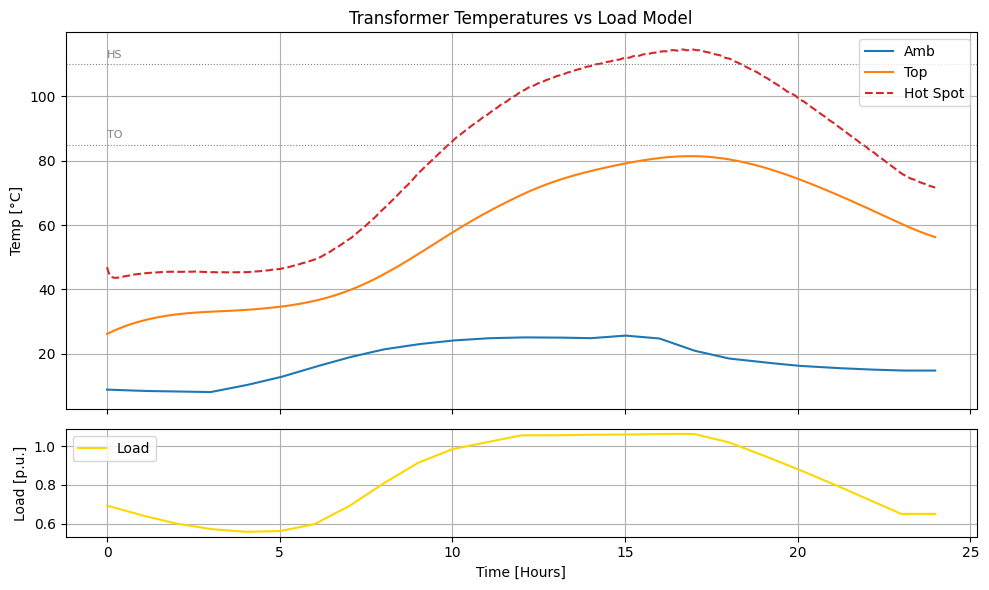

In [6]:
import matplotlib.pyplot as plt

# Extract results
solution = model.xfmr.solution
time_hr = solution['Time [Minutes]'] / 60
hotspot = solution['Hot Spot [C]']
top_oil = solution['Top Oil [C]']
ambient = solution['Ambient [C]']
load = solution['Load']

# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3.5, 1]})
fig.subplots_adjust(hspace=0.05)

# Top panel: temperatures
axs[0].plot(time_hr, ambient, label='Amb', color='tab:blue')
axs[0].plot(time_hr, top_oil, label='Top', color='tab:orange')
axs[0].plot(time_hr, hotspot, label='Hot Spot', linestyle='--', color='tab:red')
axs[0].set_ylabel('Temp [°C]')
axs[0].legend(loc='upper right')
axs[0].grid(True)
axs[0].set_title('Transformer Temperatures vs Load Model')

# Optional reference lines
axs[0].axhline(110, color='gray', linestyle=':', linewidth=0.8)
axs[0].text(time_hr.iloc[0], 112, 'HS', fontsize=8, color='gray')
axs[0].axhline(85, color='gray', linestyle=':', linewidth=0.8)
axs[0].text(time_hr.iloc[0], 87, 'TO', fontsize=8, color='gray')

# Bottom panel: load
axs[1].plot(time_hr, load, label='Load', color='gold')
axs[1].set_ylabel('Load [p.u.]')
axs[1].set_xlabel('Time [Hours]')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.tight_layout()
plt.show()
